In [49]:
#dataset from: https://www.kaggle.com/datasets/abdullah0a/retail-sales-data-with-seasonal-trends-and-marketing/data

In [20]:
import pandas as pd

file_path = "Retail and wherehouse Sale.csv"
df = pd.read_csv(file_path)

df.head()

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0


In [21]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              30000 non-null  int64  
 1   MONTH             30000 non-null  int64  
 2   SUPPLIER          29967 non-null  object 
 3   ITEM CODE         30000 non-null  object 
 4   ITEM DESCRIPTION  30000 non-null  object 
 5   ITEM TYPE         30000 non-null  object 
 6   RETAIL SALES      29999 non-null  float64
 7   RETAIL TRANSFERS  30000 non-null  float64
 8   WAREHOUSE SALES   30000 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.1+ MB


YEAR                 0
MONTH                0
SUPPLIER            33
ITEM CODE            0
ITEM DESCRIPTION     0
ITEM TYPE            0
RETAIL SALES         1
RETAIL TRANSFERS     0
WAREHOUSE SALES      0
dtype: int64

In [22]:
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df.columns

Index(['year', 'month', 'supplier', 'item_code', 'item_description',
       'item_type', 'retail_sales', 'retail_transfers', 'warehouse_sales'],
      dtype='object')

In [23]:
df['supplier'] = df['supplier'].fillna('Unknown')

df = df[df['retail_sales'].notna()]
df.isnull().sum()

year                0
month               0
supplier            0
item_code           0
item_description    0
item_type           0
retail_sales        0
retail_transfers    0
warehouse_sales     0
dtype: int64

In [24]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///retail_sales.db')

df.to_sql('sales', con=engine, index=False, if_exists='replace')

29999

In [26]:
import sqlite3

# Connect to the database
conn = sqlite3.connect("retail_sales.db")

# Total Retail Sales Per Year
query = """
SELECT year, SUM(retail_sales) AS total_sales
FROM sales
GROUP BY year
ORDER BY year;
"""

pd.read_sql_query(query, conn)

,year,total_sales
0,2020,208186.94


In [27]:
# Top 5 Selling Item Types by Total Retail Sales
query = """
SELECT item_type, ROUND(SUM(retail_sales), 2) AS total_sales
FROM sales
GROUP BY item_type
ORDER BY total_sales DESC
LIMIT 5;
"""

pd.read_sql_query(query, conn)

,item_type,total_sales
0,LIQUOR,81742.85
1,WINE,59688.84
2,BEER,59538.76
3,NON-ALCOHOL,6824.62
4,STR_SUPPLIES,345.60


In [28]:
#Total Retail vs Warehouse Sales per Supplier
query = """
SELECT supplier, 
       ROUND(SUM(retail_sales), 2) AS total_retail_sales,
       ROUND(SUM(warehouse_sales), 2) AS total_warehouse_sales
FROM sales
GROUP BY supplier
ORDER BY total_retail_sales DESC;
"""

pd.read_sql_query(query, conn)

,supplier,total_retail_sales,total_warehouse_sales
0,DIAGEO NORTH AMERICA INC,13840.54,20807.36
1,E & J GALLO WINERY,12742.24,17734.00
2,ANHEUSER BUSCH INC,10091.64,137538.52
3,CONSTELLATION BRANDS,9931.78,11193.01
4,JIM BEAM BRANDS CO,9845.79,757.76
...,...,...,...
286,BREWDOG BREWING COMPANY LLC,0.00,1.00
287,BASQUE BAR LLC,0.00,117.00
288,AMERICAN FIDELITY TRADING,0.00,4.00
289,ALLIED IMPORTERS USA LTD,0.00,1.00


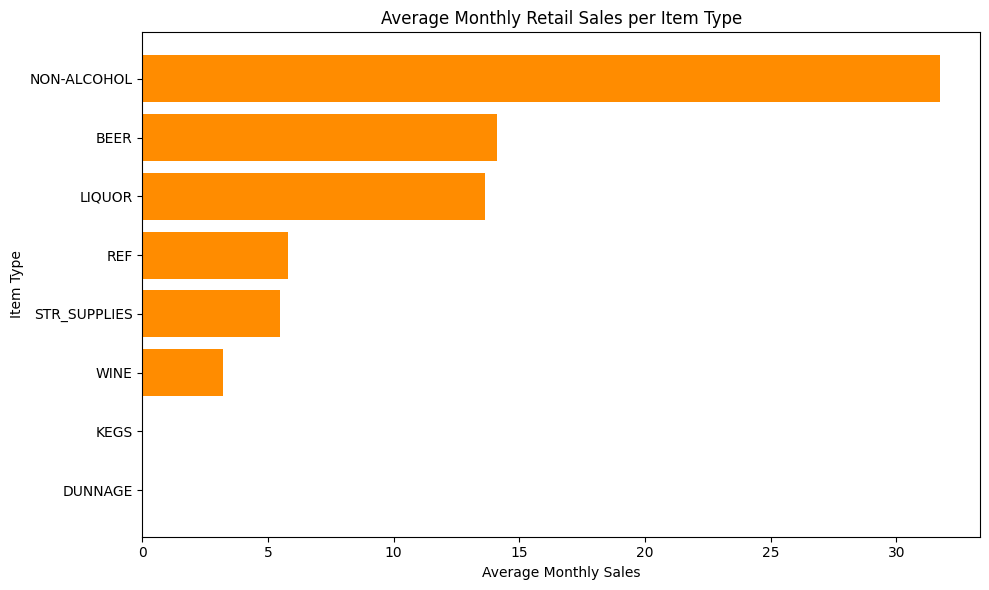

In [38]:
# Average Monthly Sales Per Item Type
query = """
SELECT item_type, 
       ROUND(AVG(retail_sales), 2) AS avg_monthly_sales
FROM sales
GROUP BY item_type
ORDER BY avg_monthly_sales DESC;
"""

pd.read_sql_query(query, conn)

avg_sales = pd.read_sql_query(query, conn)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(avg_sales['item_type'], avg_sales['avg_monthly_sales'], color='darkOrange')
plt.xlabel("Average Monthly Sales")
plt.ylabel("Item Type")
plt.title("Average Monthly Retail Sales per Item Type")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [34]:
#Months Where Retail Sales Were Less Than Transfers (Red Flag)
query = """
SELECT year, month,
       ROUND(SUM(retail_sales), 2) AS total_retail_sales,
       ROUND(SUM(retail_transfers), 2) AS total_transfers
FROM sales
GROUP BY year, month
HAVING SUM(retail_sales) < SUM(retail_transfers)
ORDER BY year, month;
"""

pd.read_sql_query(query, conn)

,year,month,total_retail_sales,total_transfers
0,2020,1,74318.77,75997.35


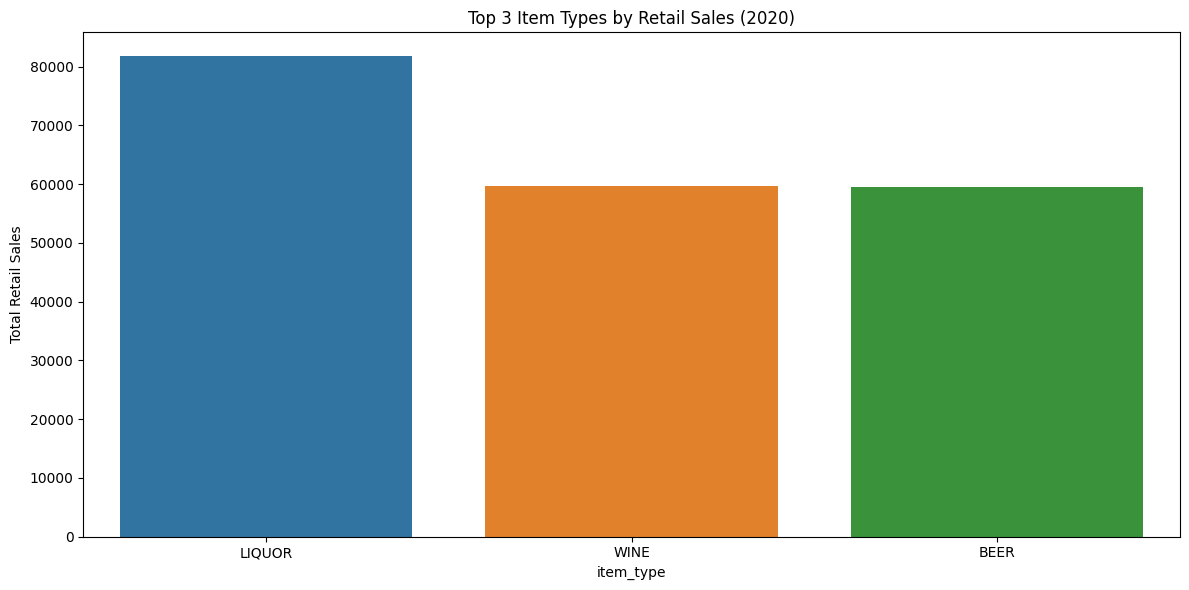

In [44]:
# CTE + Window Function 
#Rank item_types within each year by total retail sales
query = """
WITH sales_by_type AS (
    SELECT year, item_type, SUM(retail_sales) AS total_sales
    FROM sales
    GROUP BY year, item_type
)
SELECT *, 
       RANK() OVER (PARTITION BY year ORDER BY total_sales DESC) AS rank_in_year
FROM sales_by_type;
"""

pd.read_sql_query(query, conn)

ranked_sales = pd.read_sql_query(query, conn)

# Plot top 3 items per year
top3 = ranked_sales[ranked_sales['rank_in_year'] <= 3]

import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=top3, x="item_type", y="total_sales", hue="item_type")
plt.title("Top 3 Item Types by Retail Sales (2020)")
plt.ylabel("Total Retail Sales")
plt.tight_layout()
plt.show()

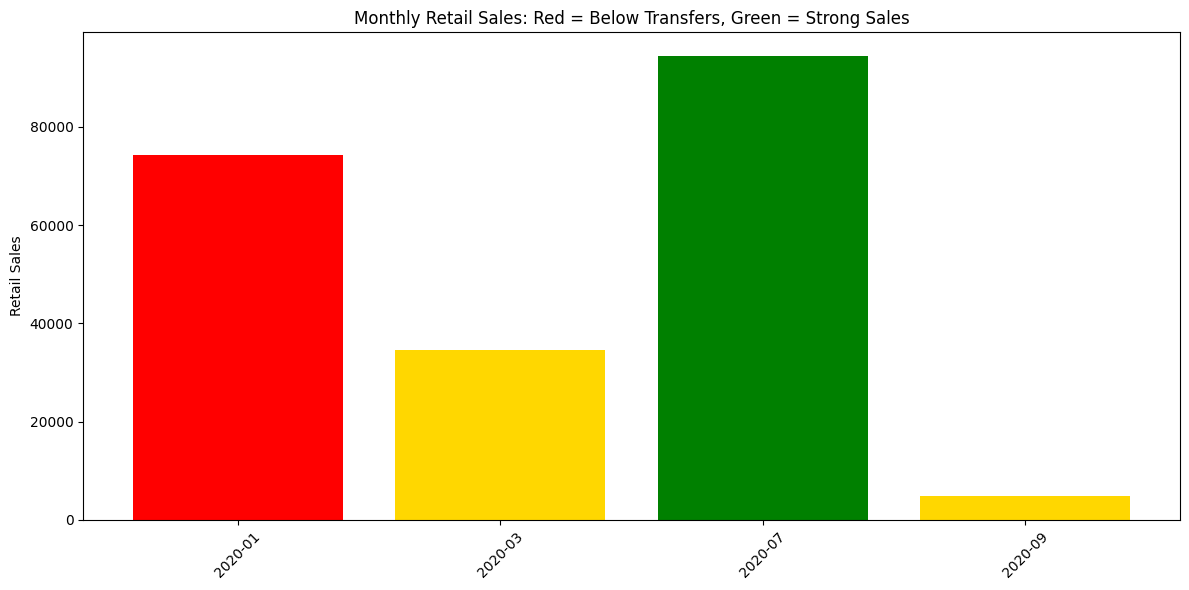

In [48]:
#Classify Months
query = """
SELECT year, month,
       ROUND(SUM(retail_sales), 2) AS total_retail_sales,
       ROUND(SUM(retail_transfers), 2) AS total_transfers
FROM sales
GROUP BY year, month
ORDER BY year, month;
"""

monthly = pd.read_sql_query(query, conn)

# Classification logic
def classify(row):
    if row['total_retail_sales'] < row['total_transfers']:
        return 'Red'
    elif row['total_retail_sales'] > row['total_transfers'] * 1.1:
        return 'Green'
    else:
        return 'Yellow'

monthly['flag'] = monthly.apply(classify, axis=1)
monthly['period'] = monthly['year'].astype(str) + "-" + monthly['month'].astype(str).str.zfill(2)
#plot
color_map = {'Red': 'red', 'Green': 'green', 'Yellow': 'gold'}

plt.figure(figsize=(12, 6))
plt.bar(monthly['period'], monthly['total_retail_sales'], 
        color=monthly['flag'].map(color_map))
plt.xticks(rotation=45)
plt.ylabel("Retail Sales")
plt.title("Monthly Retail Sales: Red = Below Transfers, Green = Strong Sales")
plt.tight_layout()
plt.show()